In [1]:
from pragmaticquant import market

mkt_datas = market.MarketDatas.load_json('mkt.json')
mkt = market.Market(mkt_datas)
print('Market RefDate = %s' % mkt.refdate())

Market RefDate = 2015-04-29 00:00:00


In [2]:
from dateutil.relativedelta import relativedelta
from pragmaticquant import model
from pragmaticquant.pricing import PricingConfig, MonteCarloAlgo

lv_model = model.localvolmodel('SP500', 
                               divmodel = {"0d" : 0.0, "3m" : 0.25, "1y" : 0.75, "10y" : 1.0})

stoch_vol = model.stochvol_params(k1=5.30, k2=0.3, nu=1.90, rho_sx=-0.58, rho_sy=-0.5, rho_xy=0.2774, theta=0.2171)
bergomi_model = model.bergomi2Fmodel('SP500', 
                                     divmodel = {"0d" : 0.0, "3m" : 0.25, "1y" : 0.75, "10y" : 1.0}, 
                                     stochvol_params=stoch_vol, )

bergomi_config = PricingConfig(algorithm = MonteCarloAlgo(70000),
                               model = bergomi_model, 
                               market = mkt_datas)

lv_config = PricingConfig(algorithm = MonteCarloAlgo(50000),
                          model = lv_model,                          
                          market = mkt_datas)

In [3]:
from pragmaticquant.pricing import get_equitysmile_viewer_task
mats = ['3m', '6m', '1y', '2y', '5y']
strikes = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
viewer=get_equitysmile_viewer_task('SP500', mats, strikes)
bergomi_smile=viewer(bergomi_config)
lv_smile=viewer(lv_config)

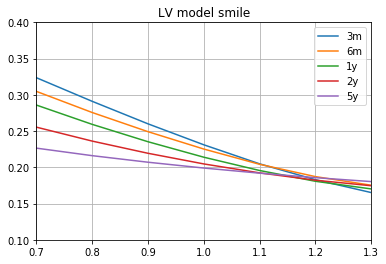

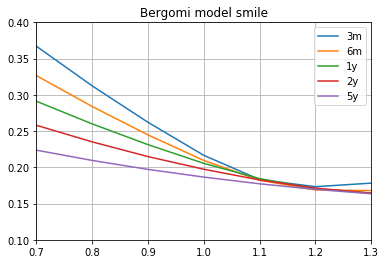

In [20]:
from pandas import DataFrame
import numpy as np

%matplotlib inline
lv_df = DataFrame(data=np.array(lv_smile).transpose(), columns=mats, index=strikes)
lv_df.plot(ylim=(0.1, 0.4), grid=True, title='LV model smile')

bergomi_df = DataFrame(data=np.array(bergomi_smile).transpose(), columns=mats, index=strikes)
bergomi_df.plot(ylim=(0.1, 0.4), grid=True, title='Bergomi model smile')

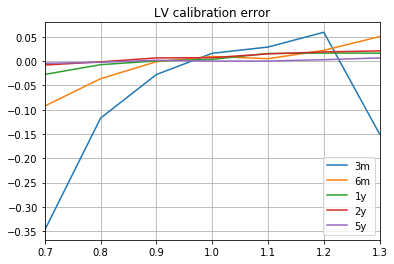

In [26]:
mkt_smile = np.array(mkt.assetvol('SP500', mats, strikes))
error = (np.array(lv_smile) - mkt_smile)*100
DataFrame(data=error.transpose(), columns=mats, index=strikes).plot(grid=True, title='LV calibration error')